<a href="https://colab.research.google.com/github/teogoulas/ml-query-optimization/blob/master/ml_query_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Connect to Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd gdrive/MyDrive/UNIPI/ml-query-optimization
%ls

/content/gdrive/MyDrive/UNIPI/ml-query-optimization
classification/  data/       main.py  README.md
config/          main.ipynb  models/  utils/


In [4]:
%cd gdrive/MyDrive/UNIPI
!git clone https://github.com/teogoulas/ml-query-optimization.git
%cd ml-query-optimization/
%ls

[Errno 2] No such file or directory: 'gdrive/MyDrive/UNIPI'
/content/gdrive/MyDrive/UNIPI/ml-query-optimization
Cloning into 'ml-query-optimization'...
remote: Enumerating objects: 383, done.
remote: Counting objects: 100% (238/238), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 383 (delta 135), reused 202 (delta 104), pack-reused 145
Receiving objects: 100% (383/383), 1.20 MiB | 7.48 MiB/s, done.
Resolving deltas: 100% (197/197), done.
/content/gdrive/MyDrive/UNIPI/ml-query-optimization/ml-query-optimization
classification/  data/       main.py  README.md
config/          main.ipynb  models/  utils/


###Imports

In [4]:
!pip install gensim==4.1.2
!pip install -Uqq ipdb

     |████████████████████████████████| 24.1 MB 68.9 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 793 kB 4.3 MB/s 
     |████████████████████████████████| 380 kB 55.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.28 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.32.0 which is incompatible.


In [5]:
import pandas as pd
from utils.vectorization import text_vectorization
from utils.downloader import get_glove_vectors
from models.embeddings_model import EmbeddingsModel
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import Word2Vec, KeyedVectors
from sklearn.manifold import TSNE
import random
import sys
import numpy as np
import pandas as pd
import string
import logging
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional
from keras.layers.embeddings import Embedding
# from keras.losses import SparseCategoricalCrossentropy
# from keras.metrics import SparseCategoricalAccuracy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import os
import time
import pickle
from tensorflow.keras import backend as K
import ipdb

In [6]:
%pdb on

Automatic pdb calling has been turned ON


###Generate training-test data

In [7]:
def import_dataset(input_filepath: str, output_filepath: str, input_column: str, target_column: str, sep=","):
  df = pd.read_csv(input_filepath, sep=sep)
  input_data = df[[input_column]]
  print(f"Input data shape: {input_data.shape}")
  df = pd.read_csv(output_filepath, sep=sep)
  target_data = df[[target_column]].apply(lambda x : x + ' <eos>')
  print(f"Target data shape: {target_data.shape}")
  target_input_data = df[[target_column]].apply(lambda x : '<sos> '+ x)
  print(f"Target input data shape: {target_input_data.shape}")

  return input_data, target_data, target_input_data

In [8]:
input_data, target_data, target_input_data = import_dataset('data/training/input_data.csv', 'data/training/output_data.csv', 'input_queries', 'output_queries')

Input data shape: (5501, 1)
Target data shape: (5501, 1)
Target input data shape: (5501, 1)


In [93]:
raw_input_data, raw_target_data, raw_target_input_data = import_dataset('data/training/raw_input_data.csv', 'data/training/raw_output_data.csv', 'input_queries', 'output_queries', ';')

Input data shape: (5595, 1)
Target data shape: (5595, 1)
Target input data shape: (5595, 1)


In [8]:
operators_input_data, operators_target_data, operators_target_input_data = import_dataset('data/training/operators_impl_input_data_v3.csv', 'data/training/operators_impl_output_data_v3.csv', 'input_queries', 'output_queries')

Input data shape: (5328, 1)
Target data shape: (5328, 1)
Target input data shape: (5328, 1)


###Vectorize inputs & outputs

In [9]:
input_vectorizer, input_corpus = text_vectorization(input_data, ['input_queries'], (1, 1))
target_vectorizer, target_corpus = text_vectorization(target_data, ['output_queries'], (1, 1))
target_input_vectorizer, target_input_corpus = text_vectorization(target_input_data, ['output_queries'], (1, 1))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk

In [99]:
print("number of input words : ", len(input_vectorizer.vocabulary_.keys()))
print("number of target words : ", len(target_vectorizer.vocabulary_.keys()))
print("number of target input words : ", len(target_input_vectorizer.vocabulary_.keys()))

number of input words :  849
number of target words :  1075
number of target input words :  1075


In [97]:
print(input_corpus[3])
print(input_data['input_queries'][3])

['join', 'model_list', '.', 'maker', 'car_makers', '.', 'id']
join model_list.maker-car_makers.id


In [87]:
operators_input_vectorizer, operators_input_corpus = text_vectorization(operators_input_data, ['input_queries'], (1, 1))
operators_target_vectorizer, operators_target_corpus = text_vectorization(operators_target_data, ['output_queries'], (1, 1))
operators_target_input_vectorizer, operators_target_input_corpus = text_vectorization(operators_target_input_data, ['output_queries'], (1, 1))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk

In [102]:
print("number of input words : ", len(operators_input_vectorizer.vocabulary_.keys()))
print("number of target words : ", len(operators_target_vectorizer.vocabulary_.keys()))
print("number of target input words : ", len(operators_target_input_vectorizer.vocabulary_.keys()))

print(operators_input_data['input_queries'][3])
print(operators_input_corpus[3])
print(operators_target_input_corpus[3])
print(operators_target_corpus[3])

number of input words :  784
number of target words :  9
number of target input words :  9
join model_list.maker-car_makers.id
['join', 'model_list', '.', 'maker', 'car_makers', '.', 'id']
['<sos>', 'hash_join']
['hash_join', '<eos>']


###Train embedding models

In [31]:
EMBEDDING_DIM = 128

In [ ]:
%cd data/
!mkdir glove
%cd glove/
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip
%cd ../../

/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data
/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/glove
--2022-02-23 16:06:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-02-23 16:06:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-02-23 16:06:27--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP

In [ ]:
%cd data
!mkdir -p embedding_models
%cd ../

/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data
/content/gdrive/MyDrive/UNIPI/ml-query-optimization


In [32]:
glove_vectors = get_glove_vectors()

In [34]:
input_encoder = EmbeddingsModel(vector_size=EMBEDDING_DIM)
input_encoder.build(input_corpus, glove_vectors)
output_encoder = EmbeddingsModel(vector_size=EMBEDDING_DIM)
output_encoder.build(np.append(target_corpus, target_input_corpus, axis=0), glove_vectors)

In [ ]:
raw_input_encoder = EmbeddingsModel()
raw_input_encoder.build(raw_input_training_corpus, glove_vectors)
raw_output_encoder = EmbeddingsModel()
raw_output_encoder.build(raw_output_training_corpus, glove_vectors)

In [90]:
operators_input_encoder = EmbeddingsModel(vector_size=EMBEDDING_DIM)
operators_input_encoder.build(operators_input_corpus, glove_vectors)
operators_output_encoder = EmbeddingsModel(vector_size=EMBEDDING_DIM)
operators_output_encoder.build(np.append(operators_target_corpus, operators_target_input_corpus, axis=0), glove_vectors)

###Plot Input & Output Embeddings

In [ ]:
def plot_embeddings(encoder: EmbeddingsModel, samples: int, title: str):
  vocab_size, embedding_size = encoder.model.wv.vectors.shape
  # Sample random words from model dictionary
  random_i = random.sample(range(vocab_size), samples)
  random_w = [encoder.model.wv.index_to_key[i] for i in random_i]

  # Generate Word2Vec embeddings of each word
  word_vecs = np.array([encoder.model.wv[w] for w in random_w])

  # Apply t-SNE to Word2Vec embeddings, reducing to 2 dims
  tsne = TSNE()
  tsne_e = tsne.fit_transform(word_vecs)

  # Plot t-SNE result
  plt.figure(figsize=(32, 32))
  plt.title(title)
  plt.scatter(tsne_e[:, 0], tsne_e[:, 1], marker='o', c=range(len(random_w)), cmap=plt.get_cmap('Spectral'))

  for label, x, y, in zip(random_w, tsne_e[:, 0], tsne_e[:, 1]):
      plt.annotate(label,
                   xy=(x, y), xytext=(0, 15),
                   textcoords='offset points', ha='right', va='bottom',
                   bbox=dict(boxstyle='round, pad=0.2', fc='yellow', alpha=0.1))
  plt.show()


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


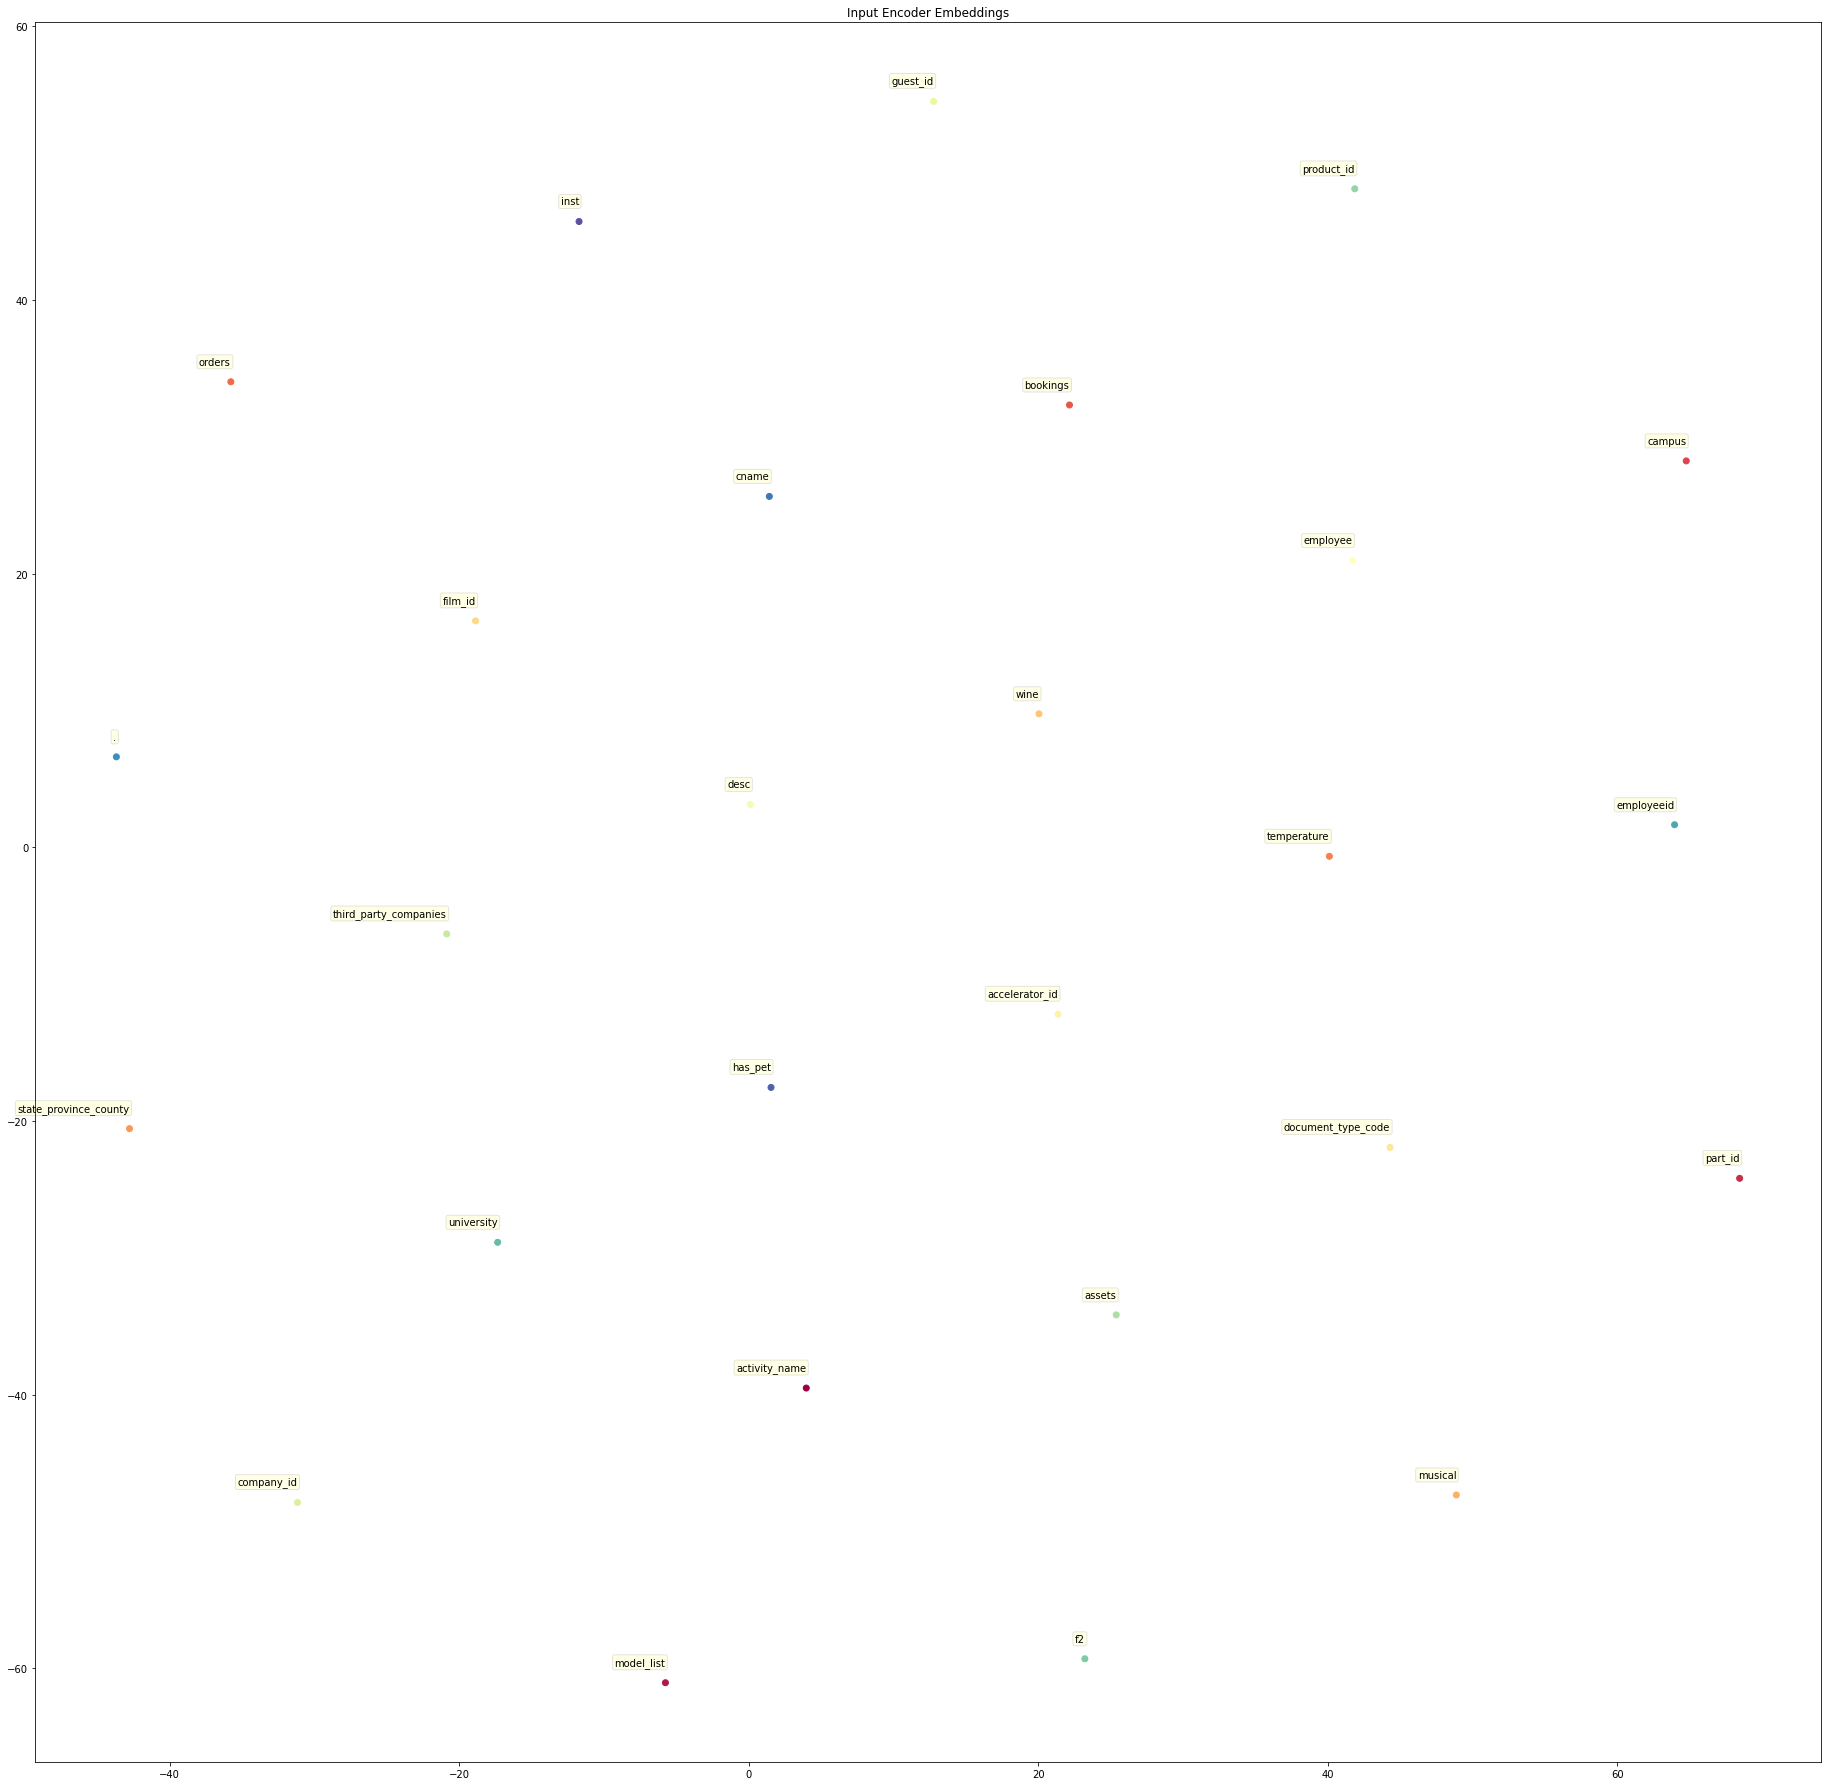

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


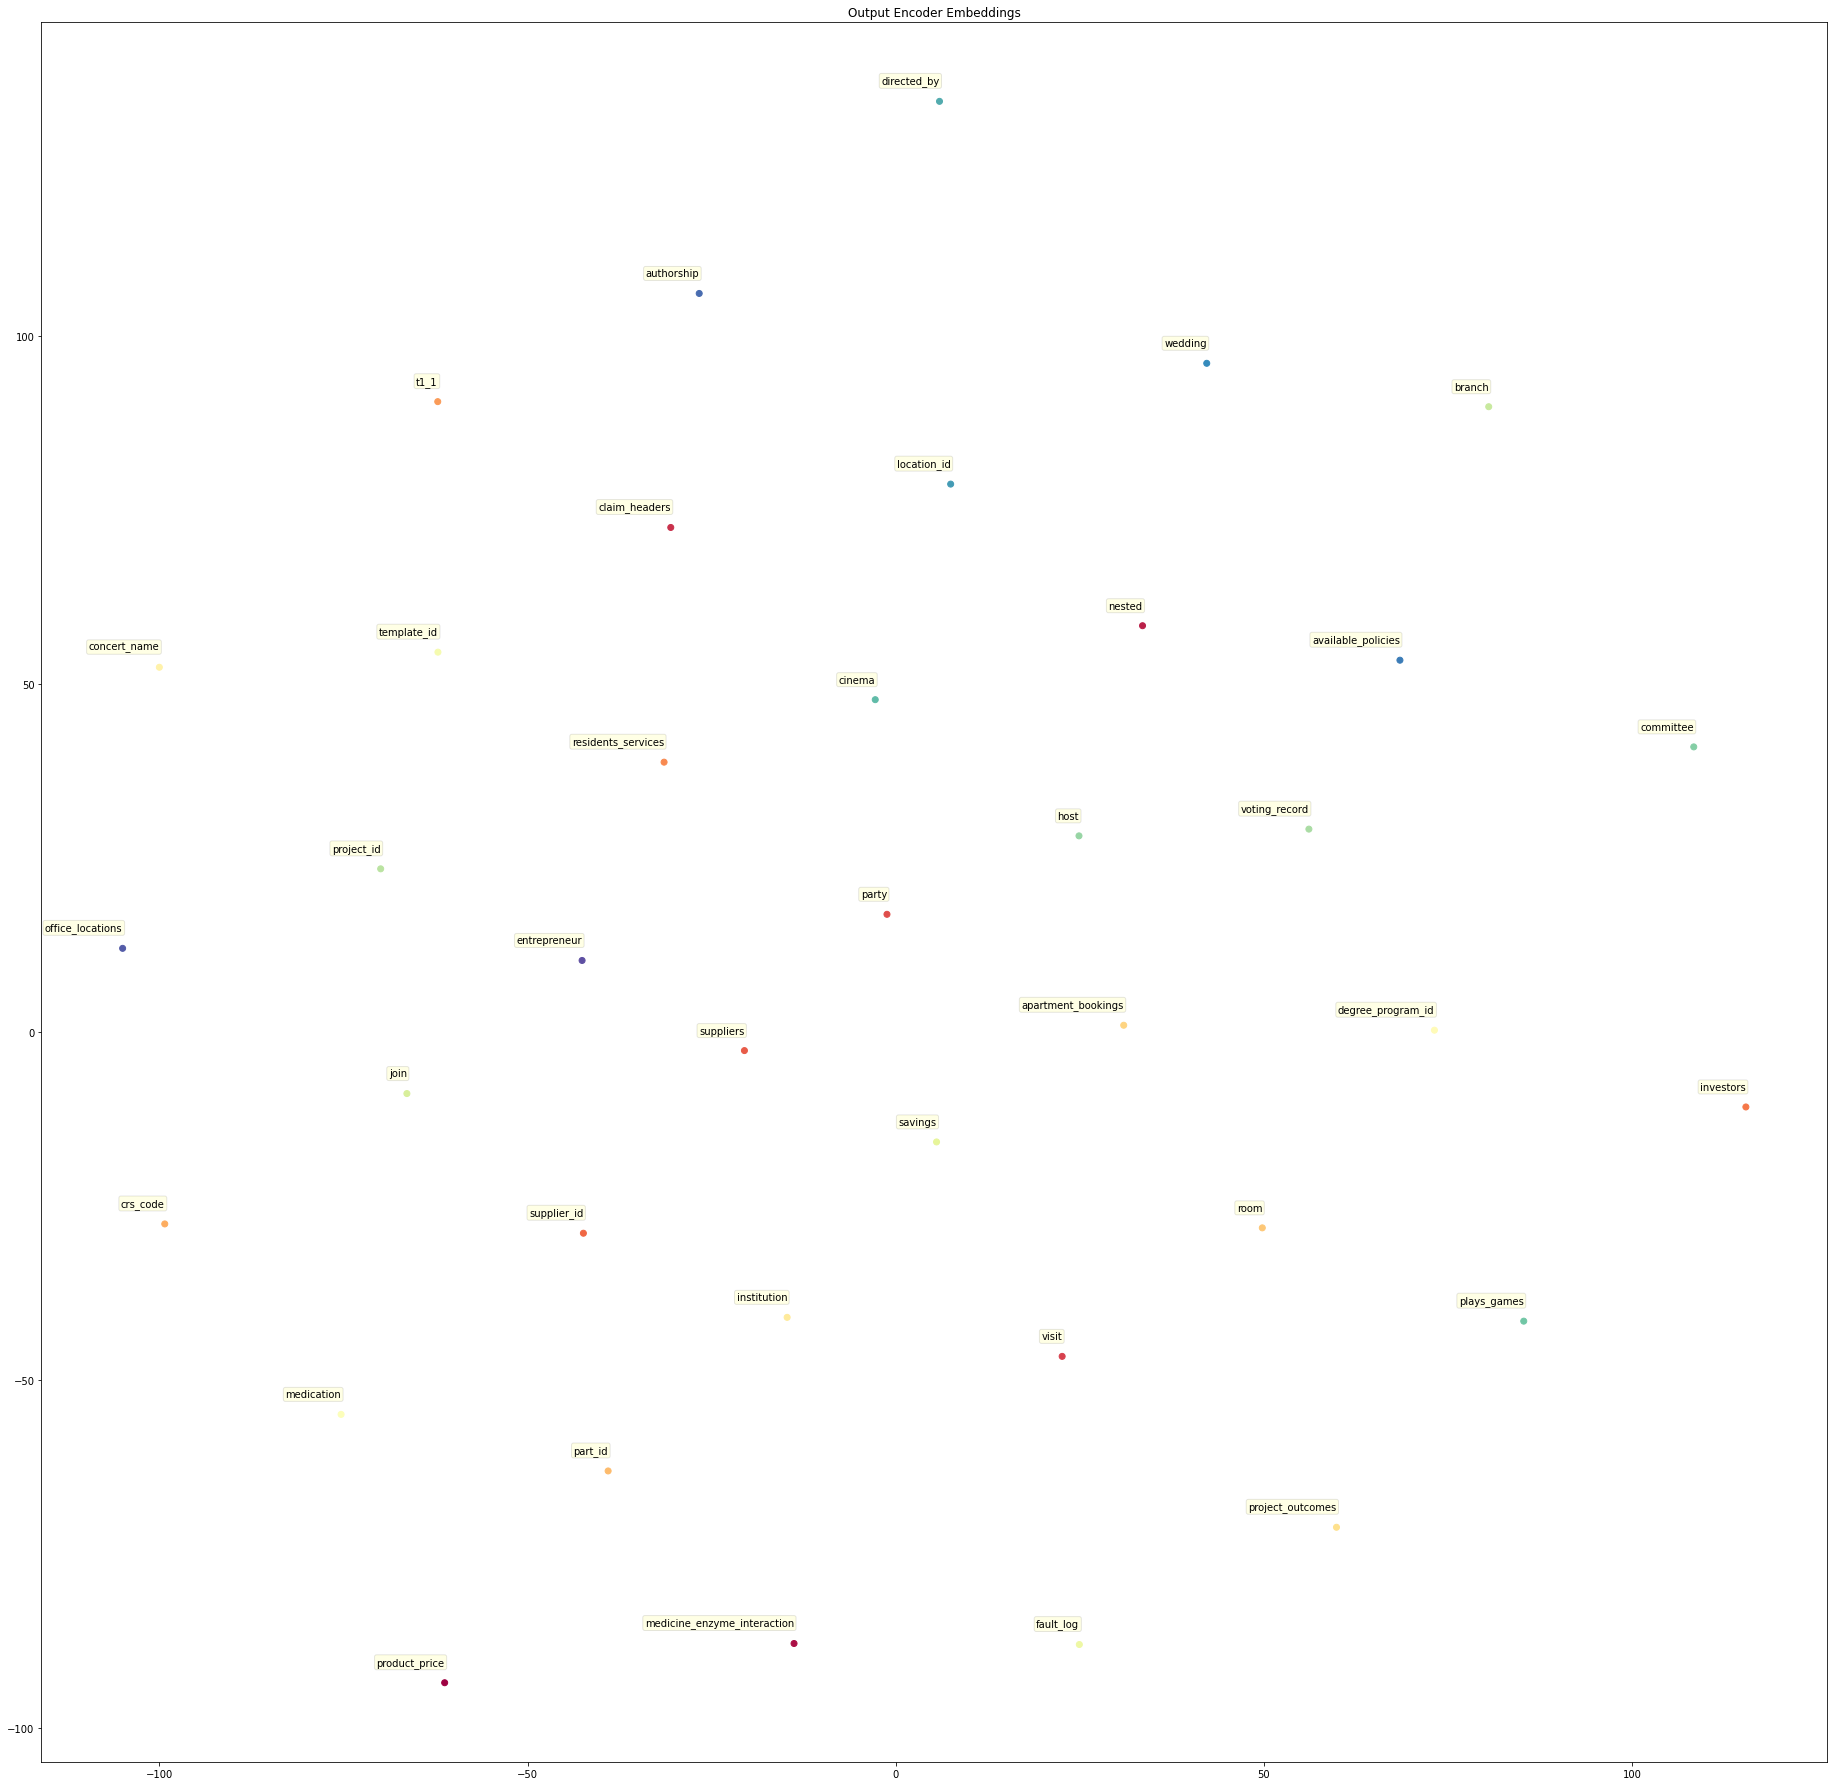

In [ ]:
plot_embeddings(input_encoder, 27, "Input Encoder Embeddings")
plot_embeddings(output_encoder, 38, "Output Encoder Embeddings")

###Save embedding models

In [35]:
filename = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/input_encoder'
input_encoder.model.save(filename)
filename = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/output_encoder'
output_encoder.model.save(filename)

In [ ]:
filename = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/raw_input_encoder'
raw_input_encoder.model.save(filename)
filename = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/raw_output_encoder'
raw_output_encoder.model.save(filename)

In [92]:
filename = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/operators_input_encoder'
operators_input_encoder.model.save(filename)
filename = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/operators_output_encoder'
operators_output_encoder.model.save(filename)

###Tokenize inputs & outputs 

In [36]:
def texts2sequences(texts: np.array, vocab: dict):
  sequences = []
  for i, text in enumerate(texts):
    seq = []
    for token in text:
      if token in vocab.keys():
        seq.append(vocab[token])
      # else:
      #   print(f"token: {token} not found at text: {text} in position: {i}!")
    sequences.append(seq)

  return sequences

In [37]:
def pad_tokenizer(x: np.array, vocab: dict):
  # tokenize input
  #tokenizer_obj = Tokenizer()
  #tokenizer_obj.fit_on_texts(x)
  sequences = texts2sequences(x, vocab)

  # pad sequences
  max_length = max([len(s) for s in x])
  vocab_size = len(vocab) + 1
  print('Found %s unique tokens.' % vocab_size)

  train_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
  
  return max_length, train_pad

In [38]:
def pad_tokenizer_bow(input_data: np.array, target_input_data=None, vocab_size=20000):

  # Create a tokenizer for the input texts and fit it to them 
  tokenizer = Tokenizer(num_words=vocab_size, filters='')
  tokenizer.fit_on_texts(input_data)
  
  if target_input_data is not None:
    tokenizer.fit_on_texts(target_input_data)
    target_input_sequences = tokenizer.texts_to_sequences(target_input_data)
  else:
    target_input_sequences = None

  # Tokenize and transform input texts to sequence of integers
  input_sequences = tokenizer.texts_to_sequences(input_data)
  # Claculate the max length
  input_max_len = max(len(s) for s in input_sequences)
  print('Max Input Length: ', input_max_len)

  # get the word to index mapping for input language
  word2idx = tokenizer.word_index
  print('Found %s unique input tokens.' % len(word2idx))

  num_words = len(word2idx) + 1
  idx2word = {v:k for k, v in word2idx.items()}

  padded_input_sequences = pad_sequences(input_sequences, maxlen=input_max_len, padding='post')
  if target_input_sequences is not None:
    padded_input_target_sequences = pad_sequences(target_input_sequences, maxlen=input_max_len, padding='post')
  else:
    padded_input_target_sequences = None

  print("padded sequences shape:", padded_input_sequences.shape)

  return input_max_len, padded_input_sequences, tokenizer, idx2word, padded_input_target_sequences

###Build model

In [39]:
EMBEDDING_DIM = 128
HIDDEN_DIM = 1024
BATCH_SIZE = 16
EPOCHS = 100
LOG_EVERY = 50
PATIENCE = 10
WAIT = 0
BEST = np.Inf
ENCODER_BEST_WEIGHTS = None
DECODER_BEST_WEIGHTS = None
BEST_EPOCH = 0
STOPPED_EPOCH = 0

In [40]:
def get_embedding_matrix(vocab, embeddings_index, embedding_dim=EMBEDDING_DIM):
  embedding_matrix = np.zeros((len(vocab) + 1, embedding_dim))
  for word, i in vocab.items():
    if word in embeddings_index.index_to_key:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embeddings_index[word]
  return embedding_matrix

In [41]:
class Encoder(Model):
    def __init__(self, vocab_size, max_length, embedding_matrix=[], num_hidden=HIDDEN_DIM, num_embedding=EMBEDDING_DIM, batch_size=BATCH_SIZE, pretrained_embeddings=True):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.num_hidden = num_hidden
        self.num_embedding = num_embedding
        self.embedding = Embedding(vocab_size, num_embedding, input_length=max_length, weights=[embedding_matrix], trainable=False) if pretrained_embeddings else Embedding(vocab_size, num_embedding)#, input_length=max_length)
        self.lstm = LSTM(num_hidden, return_sequences=True,
                                    recurrent_initializer='glorot_uniform',
                                    return_state=True)
        
    def call(self, input_sequence, states):
        embedded = self.embedding(input_sequence) #converts integer tokens into a dense representation
        # print(f"embedded shape = {embedded.shape}")
        # print(f"hidden shape = {hidden.shape}")
        output, state_h, state_c = self.lstm(embedded, initial_state=states)
        # print(f"rnn_out shape = {rnn_out.shape}")
        # print(f"hidden shape = {hidden.shape}")
        return output, state_h, state_c

    def init_hidden(self, batch_size=16):
        # Return a all 0s initial states
        return (tf.zeros([batch_size, self.num_hidden]),
                tf.zeros([batch_size, self.num_hidden]))

In [42]:
class LuongAttention(Model):
    def __init__(self, rnn_size, attention_func):
        super(LuongAttention, self).__init__()
        self.attention_func = attention_func

        if attention_func not in ['dot', 'general', 'concat']:
            raise ValueError(
                'Attention score must be either dot, general or concat.')

        if attention_func == 'general':
            # General score function
            self.wa = tf.keras.layers.Dense(rnn_size)
        elif attention_func == 'concat':
            # Concat score function
            self.wa = tf.keras.layers.Dense(rnn_size, activation='tanh')
            self.va = tf.keras.layers.Dense(1)
        
    def call(self, decoder_output, encoder_output):
        if self.attention_func == 'dot':
            # Dot score function: decoder_output (dot) encoder_output
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, encoder_output, transpose_b=True) # (batch_size, 1, max_len)
        elif self.attention_func == 'general':
            # General score function: decoder_output (dot) (Wa (dot) encoder_output)
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, self.wa(
                encoder_output), transpose_b=True) #(batch_size, 1, max_len)
        elif self.attention_func == 'concat':
            # Concat score function: va (dot) tanh(Wa (dot) concat(decoder_output + encoder_output))
            # Decoder output must be broadcasted to encoder output's shape first
            decoder_output = tf.tile(
                decoder_output, [1, encoder_output.shape[1], 1]) #shape (batch size, max len,hidden_dim)

            # Concat => Wa => va
            # (batch_size, max_len, 2 * rnn_size) => (batch_size, max_len, rnn_size) => (batch_size, max_len, 1)
            score = self.va(
                self.wa(tf.concat((decoder_output, encoder_output), axis=-1))) # (batch_size, max len, 1)

            # Transpose score vector to have the same shape as other two above
            # (batch_size, max_len, 1) => (batch_size, 1, max_len)
            score = tf.transpose(score, [0, 2, 1]) #(batch_size, 1, max_len)

        # alignment a_t = softmax(score)
        alignment = tf.keras.activations.softmax(score, axis=-1) #(batch_size, 1, max_len)
        
        # context vector c_t is the weighted average sum of encoder output
        context = tf.matmul(alignment, encoder_output) # (batch_size, 1, hidden_dim)

        return context, alignment

In [43]:
class Decoder(Model):
    def __init__(self, vocab_size, max_length, embedding_matrix=[], attention_func='concat', hidden_dim=HIDDEN_DIM, num_embedding=EMBEDDING_DIM, batch_size=BATCH_SIZE, pretrained_embeddings=True):
        super(Decoder, self).__init__()
        
        self.attn = LuongAttention(hidden_dim, attention_func)
        self.embedding = Embedding(vocab_size, num_embedding, input_length=max_length, weights=[embedding_matrix], trainable=False) if pretrained_embeddings else Embedding(vocab_size, num_embedding)#, input_length=max_length)
        self.lstm = LSTM(hidden_dim, recurrent_initializer='glorot_uniform',
                                   return_sequences=True, return_state=True)
        self.fc = Dense(hidden_dim, activation='tanh')
        self.fs = Dense(vocab_size)
        
    def call(self, input_sequence, state, encoder_output):
        # ipdb.set_trace()
        # Remember that the input to the decoder
        # is now a batch of one-word sequences,
        # which means that its shape is (batch_size, 1)
        embed = self.embedding(input_sequence)

        # Therefore, the lstm_out has shape (batch_size, 1, hidden_dim)
        lstm_out, state_h, state_c = self.lstm(embed, initial_state=state)

        # Use self.attn to compute the context and alignment vectors
        # context vector's shape: (batch_size, 1, hidden_dim)
        # alignment vector's shape: (batch_size, 1, source_length)
        context, alignment = self.attn(lstm_out, encoder_output)

        # Combine the context vector and the LSTM output
        # Before combined, both have shape of (batch_size, 1, hidden_dim),
        # so let's squeeze the axis 1 first
        # After combined, it will have shape of (batch_size, 2 * hidden_dim)
        lstm_out = tf.concat(
            [tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)

        # lstm_out now has shape (batch_size, hidden_dim)
        lstm_out = self.fc(lstm_out)

        # Finally, it is converted back to vocabulary space: (batch_size, vocab_size)
        logits = self.fs(lstm_out)

        return logits, state_h, state_c, alignment

In [44]:
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# # train_loss_metric = tf.keras.metrics.SparseCategoricalCrossentropy()
# val_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
# #val_loss_metric = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

In [45]:
def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
    # Mask padding values, they do not have to compute for loss
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    # Calculate the loss value
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss

def accuracy_fn(y_true, y_pred):
    # y_pred shape is batch_size, seq length, vocab size
    # y_true shape is batch_size, seq length
    pred_values = K.cast(K.argmax(y_pred, axis=-1), dtype='int32')
    correct = K.cast(K.equal(y_true, pred_values), dtype='float32')

    # 0 is padding, don't include those
    mask = K.cast(K.greater(y_true, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
  
    return n_correct / n_total

In [46]:
def train_step(input_tensor, target_seq_in, target_seq_out, enc_hidden, encoder, decoder, optimizer):
    loss = 0.0
    acc = 0.0
    logits = None

    with tf.GradientTape() as tape:
        enc_output, de_state_h, de_state_c = encoder(input_tensor, enc_hidden)
        # ipdb.set_trace()
        for tx in range(target_seq_out.shape[1]):
            # ipdb.set_trace()
            decoder_in = tf.expand_dims(target_seq_in[:, tx], 1)
            logit, de_state_h, de_state_c, _ = decoder(decoder_in, (de_state_h, de_state_c),
                                            enc_output)
            loss += loss_func(target_seq_out[:, tx], logit)
            # Store the logits to calculate the accuracy
            logit = K.expand_dims(logit, axis=1)
            if logits is None:
                logits = logit
            else:
                logits = K.concatenate((logits,logit), axis=1)
        
        # Calculate the accuracy for the batch data        
        acc = accuracy_fn(target_seq_out, logits)

    batch_loss = loss / target_seq_out.shape[1]
    
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss, acc

In [47]:
def test_step(input_tensor, target_seq_in, target_seq_out, enc_hidden, encoder, decoder): #input_tensor, target_tensor, enc_hidden, encoder, decoder 
  loss = 0.0
  accuracy = 0.0
  logits = None
  enc_output, de_state_h, de_state_c = encoder(input_tensor, enc_hidden)
  # ipdb.set_trace()
  for tx in range(target_seq_out.shape[1]):
      # ipdb.set_trace()
      decoder_in = tf.expand_dims(target_seq_in[:, tx], 1)
      logit, de_state_h, de_state_c, _ = decoder(decoder_in, (de_state_h, de_state_c),
                                      enc_output)
      loss += loss_func(target_seq_out[:, tx], logit)
      # Store the logits to calculate the accuracy
      logit = K.expand_dims(logit, axis=1)
      if logits is None:
          logits = logit
      else:
          logits = K.concatenate((logits,logit), axis=1)
  acc = accuracy_fn(target_seq_out, logits)
      

  batch_loss = loss / target_seq_out.shape[1]

  return batch_loss, acc

In [48]:
def main_train(train_encoder_inputs, train_decoder_inputs, train_decoder_outputs,
               val_encoder_inputs, val_decoder_inputs, val_decoder_outputs,
               input_encoder, x_max_length, output_encoder, y_max_length, checkpoint_dir, results_dir,
               pretrained_embeddings=True, idx2word_input={}, idx2word_output={},
               epochs=EPOCHS, log_every=LOG_EVERY, best=BEST, best_epoch=BEST_EPOCH, encoder_best_weights=ENCODER_BEST_WEIGHTS,
               decoder_best_weights=DECODER_BEST_WEIGHTS, wait=WAIT, patience=PATIENCE, stopped_epoch=STOPPED_EPOCH,
               num_hidden=HIDDEN_DIM, batch_size=BATCH_SIZE, attention_func='general'):
  
  buffer_size = len(train_encoder_inputs)
  dataset = tf.data.Dataset.from_tensor_slices((train_encoder_inputs, train_decoder_inputs, train_decoder_outputs)).shuffle(buffer_size)
  dataset = dataset.batch(batch_size)
  steps_per_epoch = buffer_size // batch_size

  buffer_size_val = len(val_encoder_inputs)
  dataset_val = tf.data.Dataset.from_tensor_slices((val_encoder_inputs, val_decoder_inputs, val_decoder_outputs)).shuffle(buffer_size_val)
  dataset_val = dataset_val.batch(batch_size)
  steps_per_epoch_val = buffer_size_val // batch_size

  if pretrained_embeddings:
    en_vocab_size = len(input_encoder.model.wv.key_to_index) + 1
    en_embedding_matrix = get_embedding_matrix(input_encoder.model.wv.key_to_index, input_encoder.model.wv)

    dec_vocab_size = len(output_encoder.model.wv.key_to_index) + 1
    dec_embedding_matrix = get_embedding_matrix(output_encoder.model.wv.key_to_index, output_encoder.model.wv)
  else:
    en_vocab_size = len(input_encoder.word_index) + 1
    en_embedding_matrix = []

    dec_vocab_size = len(output_encoder.word_index) + 1
    dec_embedding_matrix = []

  encoder = Encoder(en_vocab_size, x_max_length, en_embedding_matrix, num_hidden, EMBEDDING_DIM, batch_size, pretrained_embeddings) #embedding_matrix=[], num_hidden=256, num_embedding=EMBEDDING_DIM, batch_size=16, pretrained_embeddings=True
  decoder = Decoder(dec_vocab_size, y_max_length, dec_embedding_matrix, 'general', num_hidden, EMBEDDING_DIM, batch_size, pretrained_embeddings)

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  optimizer = Adam(0.005)
  checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

  for e in range(1, epochs):
    start_time = time.time()
    total_loss = 0.0
    total_accuracy = 0.0
    enc_hidden = encoder.init_hidden(batch_size)

    for idx, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(steps_per_epoch)):
        # print("idx: {0}, input_tensor shape: {1}, target_tensor shape: {2}".format(idx, input_tensor.shape,
        #                                                                            output_tensor.shape))
        batch_loss, batch_accuracy = train_step(input_seq, target_seq_in, target_seq_out, enc_hidden, encoder, decoder, optimizer)
        total_loss += batch_loss
        total_accuracy += batch_accuracy

        if idx % log_every == 0:
            print("Epochs: {} batch {}/{} | batch_accuracy: {:.4f} | batch_loss: {:.4f}".format(e, idx, steps_per_epoch, batch_accuracy, batch_loss))

    train_acc = total_accuracy / steps_per_epoch
    train_accuracies.append(train_acc)
    train_loss = total_loss / steps_per_epoch
    train_losses.append(train_loss)
    checkpoint.save(file_prefix = checkpoint_dir)
    print("Epoch: {} | Training accuracy over epoch: {:.4f} | Training loss over epoch: {:.4f}".format(e, float(train_acc), float(train_loss)))

    total_loss = 0.0
    total_accuracy = 0.0
    for idx, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset_val.take(steps_per_epoch_val)):
      batch_loss, batch_accuracy = test_step(input_seq, target_seq_in, target_seq_out, enc_hidden, encoder, decoder)
      total_loss += batch_loss
      total_accuracy += batch_accuracy

    val_acc = total_accuracy / steps_per_epoch_val
    val_accuracies.append(val_acc)
    val_loss = total_loss / steps_per_epoch_val
    val_losses.append(val_loss)
    print("Epoch: {} | Validation acc: {:.4f} | Validation loss: {:.4f}".format(e, float(val_acc), float(val_loss)))
    print("Time taken: %.2fs" % (time.time() - start_time))

    # if e % 2 == 0:
        # print("Epochs: {}/{} | total_loss: {:.4f} | total_accuracy: {:.4f}".format(
        #     e, EPOCHS, total_loss / steps_per_epoch, total_accuracy / steps_per_epoch))
    #    print("Epochs: {}/{} | total_loss: {:.4f}".format(e, EPOCHS, total_loss / steps_per_epoch))
    
    # The early stopping strategy: stop the training if `val_loss` does not
    # decrease over a certain number of epochs.
    
    if np.less(val_loss, best):
      best = val_loss
      wait = 0
      best_epoch = e
      # Record the best weights if current results is better (less).
      encoder_best_weights = encoder.get_weights()
      decoder_best_weights = decoder.get_weights()
    else:
      wait += 1
      if wait >= patience:
        stopped_epoch = e
        encoder.stop_training = True
        decoder.stop_training = True
        print(f"Early stopping activated! Restoring model weights from the end of the (best) epoch: {best_epoch}.")
        encoder.set_weights(encoder_best_weights)
        decoder.set_weights(decoder_best_weights)
        checkpoint.save(file_prefix = checkpoint_dir)
        break

  with open(results_dir, "wb") as f:
    results = {
      'train_losses': train_losses, 
      'train_accuracies': train_accuracies, 
      'val_losses': val_losses, 
      'val_accuracies': val_accuracies 
    }
    pickle.dump(results, f)


###Predict - Inference model

In [23]:
from sklearn.metrics import accuracy_score

def predict_seq2seq_att(input_text, input_max_len, input_encoder, output_encoder, encoder, decoder, output_text, output_max_len, idx2word_outputs={}, pretrained_embeddings=True):
    print(input_text)
    # print(output_text)
    # Tokenize the input text
    # print(f"pretrained_embeddings: {pretrained_embeddings}")
    input_seq = texts2sequences([input_text], input_encoder.model.wv.key_to_index) if pretrained_embeddings else input_encoder.texts_to_sequences([input_text])
    # Pad the sentence
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    # input_seq = input_text
    # Get the encoder initial states
    en_initial_states = encoder.init_hidden(1)
    # Get the encoder outputs or hidden states
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Set the decoder input to the sos token
    idx = output_encoder.model.wv.key_to_index['<sos>'] if pretrained_embeddings else output_encoder.word_index['<sos>']
    de_input = tf.constant([[idx]])
    # Set the initial hidden states of the decoder to the hidden states of the encoder
    de_state_h, de_state_c = en_outputs[1:]
    
    out_words = []
    out_sequence = []
    alignments = []
    # ipdb.set_trace()
    prediction_length = output_text.count('scan') + output_text.count('join')
    while True:
        # Get the decoder with attention output
        # ipdb.set_trace()
        de_output, de_state_h, de_state_c, alignment = decoder(
            de_input, (de_state_h, de_state_c), en_outputs[0])
        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
        # Detokenize the output
        word = output_encoder.model.wv.index_to_key[de_input.numpy()[0][0]] if pretrained_embeddings else idx2word_outputs[de_input.numpy()[0][0]]
        out_words.append(word)
        out_sequence.append(de_input.numpy()[0][0])
        # Save the aligment matrix
        alignments.append(alignment.numpy())

        if word == '<eos>':
            break
        elif len(out_words) >= prediction_length:
          out_words.append('<eos>')
          idx = output_encoder.model.wv.key_to_index['<eos>'] if pretrained_embeddings else output_encoder.word_index['<eos>']
          out_sequence.append(idx)
          break
    # Join the output words
    # ipdb.set_trace()
    padded_out = pad_sequences([out_sequence], maxlen=output_max_len, padding='post')[0]

    output_seq = texts2sequences([output_text], output_encoder.model.wv.key_to_index) if pretrained_embeddings else output_encoder.texts_to_sequences([output_text])
    # Pad the sentence
    output_seq = pad_sequences(output_seq, maxlen=output_max_len, padding='post')[0]
    acc = accuracy_score(output_seq, padded_out)
    
    return np.array(alignments), input_text, out_words, acc

In [24]:
def generate_predictions(X_test, y_test, input_encoder, output_encoder, checkpoint_dir, x_test_max_length, y_test_max_length, idx2word_input=None, idx2word_output=None, pretrained_embeddings=True):
  # tokenize input
  print(x_test_max_length)
  print(y_test_max_length)

  predict_optimizer = tf.keras.optimizers.Adam(0.005)
  encoder = Encoder(len(input_encoder.model.wv.key_to_index if pretrained_embeddings else idx2word_input) + 1, x_test_max_length, get_embedding_matrix(input_encoder.model.wv.key_to_index, input_encoder.model.wv) if pretrained_embeddings else [], 256, EMBEDDING_DIM, 16, pretrained_embeddings)
  decoder = Decoder(len(output_encoder.model.wv.key_to_index if pretrained_embeddings else idx2word_output) + 1, y_test_max_length, get_embedding_matrix(output_encoder.model.wv.key_to_index, output_encoder.model.wv) if pretrained_embeddings else [], 'concat', 256, EMBEDDING_DIM, 16, pretrained_embeddings)

  checkpoint = tf.train.Checkpoint(optimizer=predict_optimizer,
                                  encoder=encoder,
                                  decoder=decoder)

  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

  test_sents = list(X_test)#[0:(0+n_predictions)]
  # ipdb.set_trace()
  # Create the figure to plot in
  # fig = plt.figure(figsize=(10, 20))
  total_acc = 0.0
  for i, test_sent in enumerate(test_sents):
      # Call the predict function to get the translation
      alignments, source, prediction, acc = predict_seq2seq_att(test_sent, x_test_max_length, input_encoder, output_encoder, encoder, decoder, y_test[i], y_test_max_length, idx2word_output, pretrained_embeddings)
      print(f"prediction: {prediction}")
      print(f"actual: {y_test[i]}")
      print(f"Accuracy: {acc}\n")
      total_acc += acc
      # attention = np.squeeze(alignments, (1, 2))
      # Create a subplot
      # ax = fig.add_subplot(1, n_predictions, i+1)
      # ax.matshow(attention[:len(prediction), :len(source)], cmap='viridis')
      # ax.set_xticklabels([''] + source, rotation=90)
      # ax.set_yticklabels([''] + prediction)

  # plt.show()
  print("Total accuracy: {:.4f}".format(total_acc / len(test_sents)))

###Experiments

####1st Experiment

In [25]:
input_encoder = EmbeddingsModel()
input_encoder.model = Word2Vec.load('/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/input_encoder')
output_encoder = EmbeddingsModel()
output_encoder.model = Word2Vec.load('/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/output_encoder')

In [27]:
input = input_corpus
target = np.column_stack((target_input_corpus, target_corpus))

print(f"Input shape: {input.shape}, Target shape: {input.shape}")

y_train, y_test, input_train, input_test = train_test_split(target, input, test_size=0.01, random_state=42)
target_input_train = y_train[:,0]
target_train = y_train[:,1]
target_input_test = y_test[:,0]
target_test = y_test[:,1]

print(f"Input train shape: {input_train.shape}, target train shape: {target_train.shape}, target input train shape: {target_input_train.shape}")
print(f"Input test shape: {input_test.shape}, target test shape: {target_test.shape}, target input test shape: {target_input_test.shape}")

x_max_length, encoder_inputs = pad_tokenizer(input_train, input_encoder.model.wv.key_to_index)
y_max_length, decoder_targets = pad_tokenizer(target_train, output_encoder.model.wv.key_to_index)
_, decoder_inputs = pad_tokenizer(target_input_train, output_encoder.model.wv.key_to_index)

dec_inputs = np.column_stack((decoder_inputs, decoder_targets))
dec_train, dec_val, train_encoder_inputs, val_encoder_inputs = train_test_split(dec_inputs, encoder_inputs, test_size=0.01, random_state=42)
train_decoder_inputs = dec_train[:,:y_max_length]
train_decoder_targets = dec_train[:,y_max_length:]
val_decoder_inputs = dec_val[:,:y_max_length]
val_decoder_targets = dec_val[:,y_max_length:]

print(f"Encoder Input train shape: {train_encoder_inputs.shape}, Decoder input train shape: {train_decoder_inputs.shape}, Decoder target train shape: {train_decoder_targets.shape}")
print(f"Encoder Input validation shape: {val_encoder_inputs.shape}, Decoder validation train shape: {val_decoder_inputs.shape}, Decoder validation train shape: {val_decoder_targets.shape}")

Input shape: (5501,), Target shape: (5501,)
Input train shape: (5445,), target train shape: (5445,), target input train shape: (5445,)
Input test shape: (56,), target test shape: (56,), target input test shape: (56,)
Found 561 unique tokens.
Found 695 unique tokens.
Found 695 unique tokens.
Encoder Input train shape: (5390, 32), Decoder input train shape: (5390, 92), Decoder target train shape: (5390, 92)
Encoder Input validation shape: (55, 32), Decoder validation train shape: (55, 92), Decoder validation train shape: (55, 92)


#####Training

In [28]:
checkpoint_dir = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/chkp'
results_dir = "/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/results.pkl"

In [29]:
main_train(train_encoder_inputs, train_decoder_inputs, train_decoder_targets,
               val_encoder_inputs, val_decoder_inputs, val_decoder_targets,
               input_encoder, x_max_length, output_encoder, y_max_length, checkpoint_dir, results_dir)

ValueError: ignored

> <ipython-input-14-caf0ce635864>(6)get_embedding_matrix()
      3   for word, i in vocab.items():
      4     if word in embeddings_index.index_to_key:
      5         # words not found in embedding index will be all-zeros.
----> 6         embedding_matrix[i] = embeddings_index[word]
      7   return embedding_matrix

ipdb> q


In [ ]:
WAIT = 0
BEST = np.Inf
ENCODER_BEST_WEIGHTS = None
DECODER_BEST_WEIGHTS = None
BEST_EPOCH = 0
STOPPED_EPOCH = 0

In [ ]:
input_tensor = tf.convert_to_tensor(X_train_pad)
output_tensor = tf.convert_to_tensor(y_train_pad)

buffer_size = len(input_tensor)
dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor)).shuffle(buffer_size)
dataset = dataset.batch(BATCH_SIZE)
steps_per_epoch = len(input_tensor) // BATCH_SIZE

input_tensor_val = tf.convert_to_tensor(X_test_pad)
output_tensor_val = tf.convert_to_tensor(y_test_pad)

buffer_size_val = len(input_tensor_val)
dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, output_tensor_val)).shuffle(buffer_size_val)
dataset_val = dataset_val.batch(BATCH_SIZE)
steps_per_epoch_val = len(input_tensor_val) // BATCH_SIZE

#hidden = tf.zeros((16, 256))
encoder = Encoder(len(input_encoder.model.wv.key_to_index) + 1, x_max_length, get_embedding_matrix(input_encoder.model.wv.key_to_index, input_encoder.model.wv))
decoder = Decoder(len(output_encoder.model.wv.key_to_index) + 1, y_max_length, get_embedding_matrix(output_encoder.model.wv.key_to_index, output_encoder.model.wv))

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

optimizer = Adam(0.005)
checkpoint_dir = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/chkp'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

for e in range(1, EPOCHS):
  start_time = time.time()
  total_loss = 0.0
  total_accuracy = 0.0
  enc_hidden = encoder.init_hidden(BATCH_SIZE)

  for idx, (input_tensor, target_tensor) in enumerate(dataset.take(steps_per_epoch)):
      # print("idx: {0}, input_tensor shape: {1}, target_tensor shape: {2}".format(idx, input_tensor.shape,
      #                                                                            output_tensor.shape))
      batch_loss, batch_accuracy = train_step(input_tensor, target_tensor, enc_hidden, encoder, decoder, optimizer)
      total_loss += batch_loss
      total_accuracy += batch_accuracy

      if idx % LOG_EVERY == 0:
          print("Epochs: {} batch {}/{} | batch_accuracy: {:.4f} | batch_loss: {:.4f}".format(e, idx, steps_per_epoch, batch_accuracy, batch_loss))

  train_acc = total_accuracy / steps_per_epoch
  train_accuracies.append(train_acc)
  train_loss = total_loss / steps_per_epoch
  train_losses.append(train_loss)
  checkpoint.save(file_prefix = checkpoint_dir)
  print("Epoch: {} | Training accuracy over epoch: {:.4f} | Training loss over epoch: {:.4f}".format(e, float(train_acc), float(train_loss)))

  total_loss = 0.0
  total_accuracy = 0.0
  for idx, (input_tensor_val, target_tensor_val) in enumerate(dataset_val.take(steps_per_epoch_val)):
    batch_loss, batch_accuracy = test_step(input_tensor_val, target_tensor_val, enc_hidden, encoder, decoder)
    total_loss += batch_loss
    total_accuracy += batch_accuracy

  val_acc = total_accuracy / steps_per_epoch_val
  val_accuracies.append(val_acc)
  val_loss = total_loss / steps_per_epoch_val
  val_losses.append(val_loss)
  print("Epoch: {} | Validation acc: {:.4f} | Validation loss: {:.4f}".format(e, float(val_acc), float(val_loss)))
  print("Time taken: %.2fs" % (time.time() - start_time))

  # if e % 2 == 0:
      # print("Epochs: {}/{} | total_loss: {:.4f} | total_accuracy: {:.4f}".format(
      #     e, EPOCHS, total_loss / steps_per_epoch, total_accuracy / steps_per_epoch))
  #    print("Epochs: {}/{} | total_loss: {:.4f}".format(e, EPOCHS, total_loss / steps_per_epoch))
  
  # The early stopping strategy: stop the training if `val_loss` does not
  # decrease over a certain number of epochs.
  
  if np.less(val_loss, BEST):
    BEST = val_loss
    WAIT = 0
    BEST_EPOCH = e
    # Record the best weights if current results is better (less).
    ENCODER_BEST_WEIGHTS = encoder.get_weights()
    DECODER_BEST_WEIGHTS = decoder.get_weights()
  else:
    WAIT += 1
    if WAIT >= PATIENCE:
      STOPPED_EPOCH = e
      encoder.stop_training = True
      decoder.stop_training = True
      print(f"Early stopping activated! Restoring model weights from the end of the (best) epoch: {BEST_EPOCH}.")
      encoder.set_weights(ENCODER_BEST_WEIGHTS)
      decoder.set_weights(DECODER_BEST_WEIGHTS)
      checkpoint.save(file_prefix = checkpoint_dir)
      break

with open("/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/results.pkl", "wb") as f:
  results = {
    'train_losses': train_losses, 
    'train_accuracies': train_accuracies, 
    'val_losses': val_losses, 
    'val_accuracies': val_accuracies 
  }
  pickle.dump(results, f)


Epochs: 1 batch 0/272 | batch_accuracy: 0.0000 | batch_loss: 6.4718
Epochs: 1 batch 50/272 | batch_accuracy: 0.8784 | batch_loss: 0.9126
Epochs: 1 batch 100/272 | batch_accuracy: 0.8956 | batch_loss: 0.7174
Epochs: 1 batch 150/272 | batch_accuracy: 0.9052 | batch_loss: 0.4726
Epochs: 1 batch 200/272 | batch_accuracy: 0.9451 | batch_loss: 0.3020
Epochs: 1 batch 250/272 | batch_accuracy: 0.9348 | batch_loss: 0.4229
Epoch: 1 | Training accuracy over epoch: 0.9095 | Training loss over epoch: 0.6245
Epoch: 1 | Validation acc: 0.9522 | Validation loss: 0.3079
Time taken: 1143.74s
Epochs: 2 batch 0/272 | batch_accuracy: 0.9547 | batch_loss: 0.2966
Epochs: 2 batch 50/272 | batch_accuracy: 0.9306 | batch_loss: 0.3665
Epochs: 2 batch 100/272 | batch_accuracy: 0.9251 | batch_loss: 0.4185
Epochs: 2 batch 150/272 | batch_accuracy: 0.9663 | batch_loss: 0.2039
Epochs: 2 batch 200/272 | batch_accuracy: 0.9684 | batch_loss: 0.1754
Epochs: 2 batch 250/272 | batch_accuracy: 0.9705 | batch_loss: 0.1683
Ep

#####Results

In [1]:
with open(results_dir, "rb") as f:
  results = pickle.load(f)

train_losses = [float(loss) for loss in results['train_losses']]
train_accuracies = [float(loss) for loss in results['train_accuracies']]
val_losses = [float(loss) for loss in results['val_losses']]
val_accuracies = [float(loss) for loss in results['val_accuracies']]

NameError: ignored

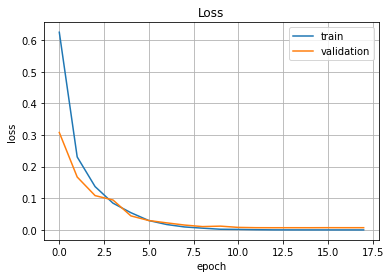

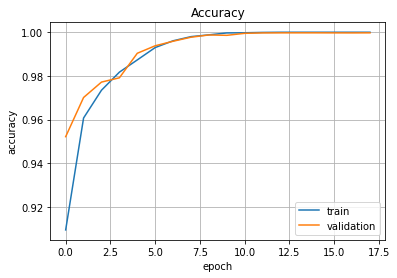

In [ ]:
fig1, ax1 = plt.subplots()

ax1.plot(train_losses, color="C0", label='train')
ax1.plot(val_losses, color="C1", label='validation')

ax1.grid(which="major", axis="both")
ax1.set_ylabel("loss")
ax1.set_xlabel("epoch")
ax1.set_title('Loss')
ax1.legend()

fig1.show()

fig2, ax2 = plt.subplots()

ax2.plot(train_accuracies, color="C0", label='train')
ax2.plot(val_accuracies, color="C1", label='validation')

ax2.grid(which="major", axis="both")
ax2.set_ylabel("accuracy")
ax2.set_xlabel("epoch")
ax2.set_title('Accuracy')
ax2.legend()

fig2.show()

#####Testing

In [ ]:
generate_predictions(X_test, y_test, input_encoder, output_encoder, '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/chkp', x_max_length, y_max_length)

33
92
prediction: ['music_festival', 'music_festival', 'music_festival', 'people', 'music_festival', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id', 'dog_id']
actual: ['inner', 'hash', 'jo

####2nd experiment

In [ ]:
raw_input_encoder = EmbeddingsModel()
raw_input_encoder.model = Word2Vec.load('/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/raw_input_encoder')
raw_output_encoder = EmbeddingsModel()
raw_output_encoder.model = Word2Vec.load('/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/raw_output_encoder')

In [ ]:
X = raw_input_training_corpus
y = raw_output_training_corpus

print(f"X shape: {X.shape}, y shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# X = raw_input_training_texts['input_queries'].values
# y = raw_output_training_texts['output_queries'].values

# tokenize input
x_max_length, X_pad = pad_tokenizer(X_train, raw_input_encoder.model.wv.key_to_index)

# tokenize output
y_max_length, y_pad = pad_tokenizer(y_train, raw_output_encoder.model.wv.key_to_index)

X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(X_pad, y_pad, test_size=0.2, random_state=42)

X shape: (5595,), y shape: (5595,)
X_train shape: (5539,), y_train shape: (5539,), X_test shape: (56,), y_test shape: (56,)
Found 1153 unique tokens.
Found 1388 unique tokens.


In [ ]:
WAIT = 0
BEST = np.Inf
ENCODER_BEST_WEIGHTS = None
DECODER_BEST_WEIGHTS = None
BEST_EPOCH = 0
STOPPED_EPOCH = 0

In [ ]:
input_tensor = tf.convert_to_tensor(X_train_pad)
output_tensor = tf.convert_to_tensor(y_train_pad)

buffer_size = len(input_tensor)
dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor)).shuffle(buffer_size)
dataset = dataset.batch(BATCH_SIZE)
steps_per_epoch = len(input_tensor) // BATCH_SIZE

input_tensor_val = tf.convert_to_tensor(X_test_pad)
output_tensor_val = tf.convert_to_tensor(y_test_pad)

buffer_size_val = len(input_tensor_val)
dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, output_tensor_val)).shuffle(buffer_size_val)
dataset_val = dataset_val.batch(BATCH_SIZE)
steps_per_epoch_val = len(input_tensor_val) // BATCH_SIZE

#hidden = tf.zeros((16, 256))
encoder = Encoder(len(raw_input_encoder.model.wv.key_to_index) + 1, get_embedding_matrix(raw_input_encoder.model.wv.key_to_index, raw_input_encoder.model.wv), x_max_length)
decoder = Decoder(len(raw_output_encoder.model.wv.key_to_index) + 1, get_embedding_matrix(raw_output_encoder.model.wv.key_to_index, raw_output_encoder.model.wv), y_max_length, 'concat')

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

optimizer = Adam(0.005)
checkpoint_dir = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/raw-chkp'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

for e in range(1, EPOCHS):
  start_time = time.time()
  total_loss = 0.0
  total_accuracy = 0.0
  enc_hidden = encoder.init_hidden(BATCH_SIZE)

  for idx, (input_tensor, target_tensor) in enumerate(dataset.take(steps_per_epoch)):
      # print("idx: {0}, input_tensor shape: {1}, target_tensor shape: {2}".format(idx, input_tensor.shape,
      #                                                                            output_tensor.shape))
      batch_loss, batch_accuracy = train_step(input_tensor, target_tensor, enc_hidden, encoder, decoder, optimizer)
      total_loss += batch_loss
      total_accuracy += batch_accuracy

      if idx % LOG_EVERY == 0:
          print("Epochs: {} batch {}/{} | batch_accuracy: {:.4f} | batch_loss: {:.4f}".format(e, idx, steps_per_epoch, batch_accuracy, batch_loss))

  train_acc = total_accuracy / steps_per_epoch
  train_accuracies.append(train_acc)
  train_loss = total_loss / steps_per_epoch
  train_losses.append(train_loss)
  checkpoint.save(file_prefix = checkpoint_dir)
  print("Epoch: {} | Training accuracy over epoch: {:.4f} | Training loss over epoch: {:.4f}".format(e, float(train_acc), float(train_loss)))

  total_loss = 0.0
  total_accuracy = 0.0
  for idx, (input_tensor_val, target_tensor_val) in enumerate(dataset_val.take(steps_per_epoch_val)):
    batch_loss, batch_accuracy = test_step(input_tensor_val, target_tensor_val, enc_hidden, encoder, decoder)
    total_loss += batch_loss
    total_accuracy += batch_accuracy

  val_acc = total_accuracy / steps_per_epoch_val
  val_accuracies.append(val_acc)
  val_loss = total_loss / steps_per_epoch_val
  val_losses.append(val_loss)
  print("Epoch: {} | Validation acc: {:.4f} | Validation loss: {:.4f}".format(e, float(val_acc), float(val_loss)))
  print("Time taken: %.2fs" % (time.time() - start_time))

  # if e % 2 == 0:
      # print("Epochs: {}/{} | total_loss: {:.4f} | total_accuracy: {:.4f}".format(
      #     e, EPOCHS, total_loss / steps_per_epoch, total_accuracy / steps_per_epoch))
  #    print("Epochs: {}/{} | total_loss: {:.4f}".format(e, EPOCHS, total_loss / steps_per_epoch))
  
  # The early stopping strategy: stop the training if `val_loss` does not
  # decrease over a certain number of epochs.
  
  if np.less(val_loss, BEST):
    BEST = val_loss
    WAIT = 0
    BEST_EPOCH = e
    # Record the best weights if current results is better (less).
    ENCODER_BEST_WEIGHTS = encoder.get_weights()
    DECODER_BEST_WEIGHTS = decoder.get_weights()
  else:
    WAIT += 1
    if WAIT >= PATIENCE:
      STOPPED_EPOCH = e
      encoder.stop_training = True
      decoder.stop_training = True
      print(f"Early stopping activated! Restoring model weights from the end of the (best) epoch: {BEST_EPOCH}.")
      encoder.set_weights(ENCODER_BEST_WEIGHTS)
      decoder.set_weights(DECODER_BEST_WEIGHTS)
      checkpoint.save(file_prefix = checkpoint_dir)
      break

with open("/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/raw_results.pkl", "wb") as f:
  results = {
    'train_losses': train_losses, 
    'train_accuracies': train_accuracies, 
    'val_losses': val_losses, 
    'val_accuracies': val_accuracies 
  }
  pickle.dump(results, f)


Epochs: 1 batch 0/276 | batch_accuracy: 0.0000 | batch_loss: 7.2301
Epochs: 1 batch 50/276 | batch_accuracy: 0.9269 | batch_loss: 0.5631
Epochs: 1 batch 100/276 | batch_accuracy: 0.9063 | batch_loss: 0.7036
Epochs: 1 batch 150/276 | batch_accuracy: 0.9031 | batch_loss: 0.7212
Epochs: 1 batch 200/276 | batch_accuracy: 0.9162 | batch_loss: 0.6337
Epochs: 1 batch 250/276 | batch_accuracy: 0.8848 | batch_loss: 0.8422
Epoch: 1 | Training accuracy over epoch: 0.9063 | Training loss over epoch: 0.7316
Epoch: 1 | Validation acc: 0.9091 | Validation loss: 0.6829
Time taken: 23718.94s
Early stopping activated! Restoring model weights from the end of the (best) epoch: 13.


ValueError: ignored

####3rd Experiment

In [ ]:
input_operators_impl_encoder = EmbeddingsModel()
input_operators_impl_encoder.model = Word2Vec.load('/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/operators_impl_input_encoder')
output_operators_impl_encoder = EmbeddingsModel()
output_operators_impl_encoder.model = Word2Vec.load('/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/embedding_models/operators_impl_output_encoder')

In [ ]:
X = input_operators_impl_training_corpus
y = output_operators_impl_training_corpus

print(f"X shape: {X.shape}, y shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}, X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# X = raw_input_training_texts['input_queries'].values
# y = raw_output_training_texts['output_queries'].values

# tokenize input
x_max_length, X_pad = pad_tokenizer(X_train, input_operators_impl_encoder.model.wv.key_to_index)

# tokenize output
y_max_length, y_pad = pad_tokenizer(y_train, output_operators_impl_encoder.model.wv.key_to_index)

X_train_pad, X_test_pad, y_train_pad, y_test_pad = train_test_split(X_pad, y_pad, test_size=0.2, random_state=42)

X shape: (5328,), y shape: (5328,)
X_train shape: (5274,), y_train shape: (5274,), X_test shape: (54,), y_test shape: (54,)
Found 517 unique tokens.
Found 9 unique tokens.


#####Training

In [ ]:
WAIT = 0
BEST = np.Inf
ENCODER_BEST_WEIGHTS = None
DECODER_BEST_WEIGHTS = None
BEST_EPOCH = 0
STOPPED_EPOCH = 0

In [ ]:
input_tensor = tf.convert_to_tensor(X_train_pad)
output_tensor = tf.convert_to_tensor(y_train_pad)

buffer_size = len(input_tensor)
dataset = tf.data.Dataset.from_tensor_slices((input_tensor, output_tensor)).shuffle(buffer_size)
dataset = dataset.batch(BATCH_SIZE)
steps_per_epoch = len(input_tensor) // BATCH_SIZE

input_tensor_val = tf.convert_to_tensor(X_test_pad)
output_tensor_val = tf.convert_to_tensor(y_test_pad)

buffer_size_val = len(input_tensor_val)
dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, output_tensor_val)).shuffle(buffer_size_val)
dataset_val = dataset_val.batch(BATCH_SIZE)
steps_per_epoch_val = len(input_tensor_val) // BATCH_SIZE

#hidden = tf.zeros((16, 256))
encoder = Encoder(len(input_operators_impl_encoder.model.wv.key_to_index) + 1, get_embedding_matrix(input_operators_impl_encoder.model.wv.key_to_index, input_operators_impl_encoder.model.wv), x_max_length)
decoder = Decoder(len(output_operators_impl_encoder.model.wv.key_to_index) + 1, get_embedding_matrix(output_operators_impl_encoder.model.wv.key_to_index, output_operators_impl_encoder.model.wv), y_max_length, 'concat')

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

optimizer = Adam(0.005)
checkpoint_dir = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/operators-impl-chkp'
checkpoint = tf.train.Checkpoint(optimizer=optimizer, encoder=encoder, decoder=decoder)

for e in range(1, EPOCHS):
  start_time = time.time()
  total_loss = 0.0
  total_accuracy = 0.0
  enc_hidden = encoder.init_hidden(BATCH_SIZE)

  for idx, (input_tensor, target_tensor) in enumerate(dataset.take(steps_per_epoch)):
      # print("idx: {0}, input_tensor shape: {1}, target_tensor shape: {2}".format(idx, input_tensor.shape,
      #                                                                            output_tensor.shape))
      batch_loss, batch_accuracy = train_step(input_tensor, target_tensor, enc_hidden, encoder, decoder, optimizer)
      total_loss += batch_loss
      total_accuracy += batch_accuracy

      if idx % LOG_EVERY == 0:
          print("Epochs: {} batch {}/{} | batch_accuracy: {:.4f} | batch_loss: {:.4f}".format(e, idx, steps_per_epoch, batch_accuracy, batch_loss))

  train_acc = total_accuracy / steps_per_epoch
  train_accuracies.append(train_acc)
  train_loss = total_loss / steps_per_epoch
  train_losses.append(train_loss)
  checkpoint.save(file_prefix = checkpoint_dir)
  print("Epoch: {} | Training accuracy over epoch: {:.4f} | Training loss over epoch: {:.4f}".format(e, float(train_acc), float(train_loss)))

  total_loss = 0.0
  total_accuracy = 0.0
  for idx, (input_tensor_val, target_tensor_val) in enumerate(dataset_val.take(steps_per_epoch_val)):
    batch_loss, batch_accuracy = test_step(input_tensor_val, target_tensor_val, enc_hidden, encoder, decoder)
    total_loss += batch_loss
    total_accuracy += batch_accuracy

  val_acc = total_accuracy / steps_per_epoch_val
  val_accuracies.append(val_acc)
  val_loss = total_loss / steps_per_epoch_val
  val_losses.append(val_loss)
  print("Epoch: {} | Validation acc: {:.4f} | Validation loss: {:.4f}".format(e, float(val_acc), float(val_loss)))
  print("Time taken: %.2fs" % (time.time() - start_time))

  # if e % 2 == 0:
      # print("Epochs: {}/{} | total_loss: {:.4f} | total_accuracy: {:.4f}".format(
      #     e, EPOCHS, total_loss / steps_per_epoch, total_accuracy / steps_per_epoch))
  #    print("Epochs: {}/{} | total_loss: {:.4f}".format(e, EPOCHS, total_loss / steps_per_epoch))
  
  # The early stopping strategy: stop the training if `val_loss` does not
  # decrease over a certain number of epochs.
  
  if np.less(val_loss, BEST):
    BEST = val_loss
    WAIT = 0
    BEST_EPOCH = e
    # Record the best weights if current results is better (less).
    ENCODER_BEST_WEIGHTS = encoder.get_weights()
    DECODER_BEST_WEIGHTS = decoder.get_weights()
  else:
    WAIT += 1
    if WAIT >= PATIENCE:
      STOPPED_EPOCH = e
      encoder.stop_training = True
      decoder.stop_training = True
      print(f"Early stopping activated! Restoring model weights from the end of the (best) epoch: {BEST_EPOCH}.")
      encoder.set_weights(ENCODER_BEST_WEIGHTS)
      decoder.set_weights(DECODER_BEST_WEIGHTS)
      checkpoint.save(file_prefix = checkpoint_dir)
      break

with open("/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/operators-impl-results.pkl", "wb") as f:
  results = {
    'train_losses': train_losses, 
    'train_accuracies': train_accuracies, 
    'val_losses': val_losses, 
    'val_accuracies': val_accuracies 
  }
  pickle.dump(results, f)


Epochs: 1 batch 0/263 | batch_accuracy: 0.7875 | batch_loss: 1.8296
Epochs: 1 batch 50/263 | batch_accuracy: 0.8375 | batch_loss: 0.3638
Epochs: 1 batch 100/263 | batch_accuracy: 1.0000 | batch_loss: 0.0204
Epochs: 1 batch 150/263 | batch_accuracy: 1.0000 | batch_loss: 0.0023
Epochs: 1 batch 200/263 | batch_accuracy: 1.0000 | batch_loss: 0.0099
Epochs: 1 batch 250/263 | batch_accuracy: 1.0000 | batch_loss: 0.0104
Epoch: 1 | Training accuracy over epoch: 0.9567 | Training loss over epoch: 0.1388
Epoch: 1 | Validation acc: 0.9967 | Validation loss: 0.0078
Time taken: 108.59s
Epochs: 2 batch 0/263 | batch_accuracy: 1.0000 | batch_loss: 0.0004
Epochs: 2 batch 50/263 | batch_accuracy: 1.0000 | batch_loss: 0.0003
Epochs: 2 batch 100/263 | batch_accuracy: 1.0000 | batch_loss: 0.0051
Epochs: 2 batch 150/263 | batch_accuracy: 1.0000 | batch_loss: 0.0009
Epochs: 2 batch 200/263 | batch_accuracy: 1.0000 | batch_loss: 0.0013
Epochs: 2 batch 250/263 | batch_accuracy: 1.0000 | batch_loss: 0.0005
Epo

##### Results

In [ ]:
with open("/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/operators-impl-results.pkl", "wb") as f:
  results = {
    'train_losses': train_losses, 
    'train_accuracies': train_accuracies, 
    'val_losses': val_losses, 
    'val_accuracies': val_accuracies 
  }
  pickle.dump(results, f)

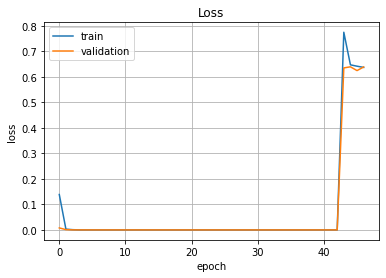

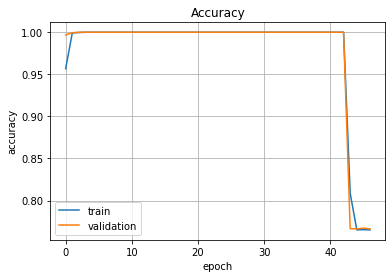

In [ ]:
fig1, ax1 = plt.subplots()

ax1.plot(train_losses, color="C0", label='train')
ax1.plot(val_losses, color="C1", label='validation')

ax1.grid(which="major", axis="both")
ax1.set_ylabel("loss")
ax1.set_xlabel("epoch")
ax1.set_title('Loss')
ax1.legend()

fig1.show()

fig2, ax2 = plt.subplots()

ax2.plot(train_accuracies, color="C0", label='train')
ax2.plot(val_accuracies, color="C1", label='validation')

ax2.grid(which="major", axis="both")
ax2.set_ylabel("accuracy")
ax2.set_xlabel("epoch")
ax2.set_title('Accuracy')
ax2.legend()

fig2.show()

#####Testing

In [ ]:
generate_predictions(X_test, y_test, input_operators_impl_encoder, output_operators_impl_encoder, '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/operators-impl-chkp', x_max_length, y_max_length)

33
6
prediction: ['nested_loop', 'index_only_scan', 'index_only_scan', 'index_only_scan', 'index_only_scan', 'index_only_scan']
actual: ['seq_scan', '<eos>']
Accuracy: 0.0
prediction: ['nested_loop', 'index_only_scan', 'index_only_scan', 'index_only_scan', 'index_only_scan', 'index_only_scan']
actual: ['seq_scan', '<eos>']
Accuracy: 0.0
prediction: ['nested_loop', 'index_only_scan', 'index_only_scan', 'index_only_scan', 'index_only_scan', 'index_only_scan']
actual: ['seq_scan', '<eos>']
Accuracy: 0.0
prediction: ['nested_loop', 'index_only_scan', 'index_only_scan', 'index_only_scan', 'index_only_scan', 'index_only_scan']
actual: ['seq_scan', '<eos>']
Accuracy: 0.0
prediction: ['nested_loop', 'index_only_scan', 'index_only_scan', 'index_only_scan', 'index_only_scan', 'index_only_scan']
actual: ['seq_scan', '<eos>']
Accuracy: 0.0
prediction: ['nested_loop', 'index_only_scan', 'index_only_scan', 'index_only_scan', 'index_only_scan', 'index_only_scan']
actual: ['index_scan', '<eos>']
Accur

#### 4th Experiment

In [57]:
input = operators_input_corpus
target = np.column_stack((operators_target_input_corpus, operators_target_corpus))

print(f"Input shape: {input.shape}, Target shape: {input.shape}")

y_train, y_test, input_train, input_test = train_test_split(target, input, test_size=0.01, random_state=42)
target_input_train = y_train[:,0]
target_train = y_train[:,1]
target_input_test = y_test[:,0]
target_test = y_test[:,1]

print(f"Input train shape: {input_train.shape}, target train shape: {target_train.shape}, target input train shape: {target_input_train.shape}")
print(f"Input test shape: {input_test.shape}, target test shape: {target_test.shape}, target input test shape: {target_input_test.shape}")

x_max_length, encoder_inputs, input_tokenizer, idx2word_input, _ = pad_tokenizer_bow(input_train)
y_max_length, decoder_targets, output_tokenizer, idx2word_output, decoder_inputs = pad_tokenizer_bow(target_train, target_input_train)

dec_inputs = np.column_stack((decoder_inputs, decoder_targets))
dec_train, dec_val, train_encoder_inputs, val_encoder_inputs = train_test_split(dec_inputs, encoder_inputs, test_size=0.01, random_state=42)
train_decoder_inputs = dec_train[:,:y_max_length]
train_decoder_targets = dec_train[:,y_max_length:]
val_decoder_inputs = dec_val[:,:y_max_length]
val_decoder_targets = dec_val[:,y_max_length:]

print(f"Encoder Input train shape: {train_encoder_inputs.shape}, Decoder input train shape: {train_decoder_inputs.shape}, Decoder target train shape: {train_decoder_targets.shape}")
print(f"Encoder Input validation shape: {val_encoder_inputs.shape}, Decoder validation train shape: {val_decoder_inputs.shape}, Decoder validation train shape: {val_decoder_targets.shape}")

Input shape: (5328,), Target shape: (5328,)
Input train shape: (5274,), target train shape: (5274,), target input train shape: (5274,)
Input test shape: (54,), target test shape: (54,), target input test shape: (54,)
Max Input Length:  32
Found 782 unique input tokens.
padded sequences shape: (5274, 32)
Max Input Length:  6
Found 10 unique input tokens.
padded sequences shape: (5274, 6)
Encoder Input train shape: (5221, 32), Decoder input train shape: (5221, 6), Decoder target train shape: (5221, 6)
Encoder Input validation shape: (53, 32), Decoder validation train shape: (53, 6), Decoder validation train shape: (53, 6)


In [34]:
print(target_train[0])
print(target_input_train[0])
print(encoder_inputs[0])
print(decoder_inputs[0])
print(decoder_targets[0])

['hash_join', 'seq_scan', '<eos>']
['<sos>', 'hash_join', 'seq_scan']
[  3  13   2 100   4   2 422   1  13   2 645   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
[3 4 1 0 0 0]
[4 1 2 0 0 0]


10

In [162]:
print(train_encoder_inputs[0])
print(train_decoder_inputs[0])
print(train_decoder_targets[0])

[ 1 68  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]
[1 2 0 0 0 0]
[3 1 0 0 0 0]


##### Training

In [56]:
checkpoint_dir = '/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/operators-impl-chkp-v2'
results_dir = "/content/gdrive/MyDrive/UNIPI/ml-query-optimization/data/weights/operators-impl-results-v2.pkl"

In [58]:
main_train(train_encoder_inputs, train_decoder_inputs, train_decoder_targets,
               val_encoder_inputs, val_decoder_inputs, val_decoder_targets,
               input_tokenizer, x_max_length, output_tokenizer, y_max_length, checkpoint_dir, results_dir, False, idx2word_input, idx2word_output)

Epochs: 1 batch 0/326 | batch_accuracy: 0.0789 | batch_loss: 0.9480
Epochs: 1 batch 50/326 | batch_accuracy: 0.9375 | batch_loss: 0.2192
Epochs: 1 batch 100/326 | batch_accuracy: 0.8438 | batch_loss: 0.2444
Epochs: 1 batch 150/326 | batch_accuracy: 0.8529 | batch_loss: 0.2020
Epochs: 1 batch 200/326 | batch_accuracy: 0.5588 | batch_loss: 0.3584
Epochs: 1 batch 250/326 | batch_accuracy: 0.4848 | batch_loss: 0.4300
Epochs: 1 batch 300/326 | batch_accuracy: 0.8571 | batch_loss: 0.1838
Epoch: 1 | Training accuracy over epoch: 0.7508 | Training loss over epoch: 0.3916
Epoch: 1 | Validation acc: 0.3819 | Validation loss: 0.4915
Time taken: 383.32s
Epochs: 2 batch 0/326 | batch_accuracy: 0.3824 | batch_loss: 0.3959
Epochs: 2 batch 50/326 | batch_accuracy: 0.8235 | batch_loss: 0.2074
Epochs: 2 batch 100/326 | batch_accuracy: 0.7778 | batch_loss: 0.3235
Epochs: 2 batch 150/326 | batch_accuracy: 0.8788 | batch_loss: 0.2058
Epochs: 2 batch 200/326 | batch_accuracy: 0.8056 | batch_loss: 0.3561
Epo

##### Results

In [59]:
with open(results_dir, "rb") as f:
  results = pickle.load(f)

train_losses = [float(loss) for loss in results['train_losses']]
train_accuracies = [float(loss) for loss in results['train_accuracies']]
val_losses = [float(loss) for loss in results['val_losses']]
val_accuracies = [float(loss) for loss in results['val_accuracies']]

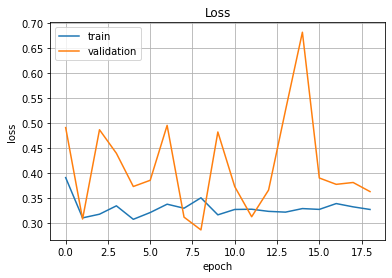

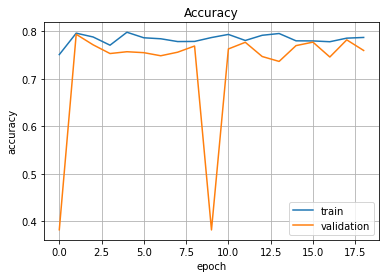

In [60]:
fig1, ax1 = plt.subplots()

ax1.plot(train_losses, color="C0", label='train')
ax1.plot(val_losses, color="C1", label='validation')

ax1.grid(which="major", axis="both")
ax1.set_ylabel("loss")
ax1.set_xlabel("epoch")
ax1.set_title('Loss')
ax1.legend()

fig1.show()

fig2, ax2 = plt.subplots()

ax2.plot(train_accuracies, color="C0", label='train')
ax2.plot(val_accuracies, color="C1", label='validation')

ax2.grid(which="major", axis="both")
ax2.set_ylabel("accuracy")
ax2.set_xlabel("epoch")
ax2.set_title('Accuracy')
ax2.legend()

fig2.show()

##### Predict

In [69]:
generate_predictions(input_test, target_test, input_tokenizer, output_tokenizer, checkpoint_dir, x_max_length, y_max_length, idx2word_input, idx2word_output, False)

32
6
['scan', 'party']
prediction: ['<sos>', '<eos>']
actual: ['seq_scan', '<eos>']
Accuracy: 0.8333333333333334

['scan', 'branch']
prediction: ['<sos>', '<eos>']
actual: ['seq_scan', '<eos>']
Accuracy: 0.8333333333333334

['scan', 'customer_address_history']
prediction: ['<sos>', '<eos>']
actual: ['seq_scan', '<eos>']
Accuracy: 0.8333333333333334

['scan', 'captain']
prediction: ['<sos>', '<eos>']
actual: ['seq_scan', '<eos>']
Accuracy: 0.8333333333333334

['scan', 'country']
prediction: ['<sos>', '<eos>']
actual: ['seq_scan', '<eos>']
Accuracy: 0.8333333333333334

['scan', 'wrestler']
prediction: ['<sos>', '<eos>']
actual: ['index_scan', '<eos>']
Accuracy: 0.8333333333333334

['scan', 'poker_player']
prediction: ['<sos>', '<eos>']
actual: ['seq_scan', '<eos>']
Accuracy: 0.8333333333333334

['scan', 'complaints']
prediction: ['<sos>', '<eos>']
actual: ['seq_scan', '<eos>']
Accuracy: 0.8333333333333334

['scan', 'flights']
prediction: ['<sos>', '<eos>']
actual: ['seq_scan', '<eos>']
A